In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
print 'success'

success


In [2]:
"""
This notebook implements the Logistic Regression in the 
"Cutting the Metropolis Hastings Budget" framework. 

The target distribution is the posterior for a logistic regression
model trained on MNIST dataset for classifying digits 7 vs 9. The 
dataset consisted of 12007 datapoints. 
"""

# get input data
mat = scipy.io.loadmat('minist7vs1.mat')
TrainLabel = mat['TrainLabel']
TrainLabel = np.reshape(TrainLabel, TrainLabel.shape[1],1)
TrainImg = mat['TrainImg']
TestImg = mat['TestImg']
TestLabel = mat['TestLabel']
print TrainLabel.shape
print TrainImg.shape
print TrainImg[0].shape
TestLabel = np.reshape(TestLabel, TestLabel.shape[1],1)

(12007,)
(12007, 784)
(784,)


In [59]:
"""
Cutting the Metropolis Hastings Budget Method
"""
def random_walk_proposer(beta_t, sigmarw):
    """
    Input: beta_t  : previous parameters, 1-D array
           sigmarw : standard deviation, 1-D array
    """
    res = (np.random.multivariate_normal(beta_t, np.diag(sigmarw))).reshape((len(beta_t),))
    return res

def ll_data(beta_t, beta_n, X, Y):
    p_x_beta_t = 1/(1 + exp(-1* Y*np.dot(beta_t,X)))
    p_x_beta_n = 1/(1 + exp(-1* Y*np.dot(beta_n,X)))
    return log(p_x_beta_n) - log(p_x_beta_t)

def eval_U0(N):
    u = np.random.random()
    return 1/N*log(u)

def make_decision(l_list, N, U0):
    n = float(len(l_list))
    l_mean = sum(l_list)/n
    l_sq = ((np.array(l_list))**2).tolist()
    l_sq_mean = sum(l_sq)/n
    sl = sqrt((l_sq_mean - l_mean*l_mean)*n/(n-1))
    s = sl/sqrt(n) * sqrt(1 - (n-1)/(N-1))
    t_stats = abs((l_mean - U0)/s)
    delta = 1 - t.cdf(t_stats, n-1)
    return delta
    
def generate_parameter(beta_t, N, sigmarw, X, Y, batchsize, epsilon ):
    U0 = eval_U0(N)
    # generate new parameter
    P = len(X[0])
    sigma = (np.matlib.repmat(sigmarw, P,1)).reshape(P,)
    beta_n = random_walk_proposer(beta_t, sigma)
    
    # make decision
    l_list = []
    for i in range(batchsize):
        mid = ll_data(beta_t, beta_n, X[i], Y[i])
        l_list.append(mid)
    
    pos = batchsize
    delta = make_decision(l_list, N, U0)
    while (delta>epsilon) and (pos < N-1):
        mid = ll_data(beta_t, beta_n, X[pos], Y[pos])
        l_list.append(mid)
        pos = pos + 1
        delta = make_decision(l_list, N, U0)
    
    l_mean = sum(l_list)/float(len(l_list))
    if l_mean > U0:
        return (beta_n,1,pos)
    else:
        return (beta_t,0,pos)
    
def eval_cost(X,Y,beta):
    N = len(Y)
    sigmoid_accuracy = 1.0/(1.0 + np.exp(-1.0 * Y * np.dot(beta, X.T)))
    accuracy = len((np.where(sigmoid_accuracy>0.5))[0])
    sigmoid = -1.0 * np.log(1.0 + np.exp(-1.0 * Y * np.dot(beta, X.T)))
    cost = np.sum(sigmoid)
    """
    accuracy = 0
    cost = 0
    for i in range(N):
        sigmoid_accuracy = 1/(1 + exp(-1* Y[i]*np.dot(beta,X[i])))
        if sigmoid_accuracy > 0.5 :
            accuracy = accuracy + 1
        sigmoid = -1.0 * np.log(1 + exp(-1 * Y[i] * np.dot(beta, X[i])))
        cost = cost + sigmoid
    """
    return (cost/float(N), accuracy/float(N))
    
def train(X, Y, sigmarw, batchsize, epsilon, niter):
    N = len(Y) # number of total training data
    P = len(X[0]) # parameter dimension
    beta_t = np.ones(P)
    # beta_t = np.random.rand(P)
    cost_list = []
    accept_pos = []
    accuracy_list = []
    for i in range(niter):
        if i % 100 == 0:
            print i
        index = np.random.permutation(N)
        X = X[index]
        Y = Y[index]
        (beta_t, mid, pos) = generate_parameter(beta_t, N, sigmarw, X,Y,batchsize,epsilon)
        (cost,accuracy) = eval_cost(TestImg, TestLabel, beta_t)
        cost_list.append(cost)
        accuracy_list.append(accuracy)
        accept_pos.append(pos)
    return (cost_list, accept_pos, accuracy_list)

X = TrainImg
Y = TrainLabel
sigmarw = 0.01
batchsize = 50
epsilon = 0.1
niter = 1000
(cost_list_xl, accept_pos_xl, accuracy_xl) = train(X, Y, sigmarw, batchsize, epsilon, niter)
print sum(accept_pos_xl)/float(len(accept_pos_xl))
cumulate_datasize_xl = [accept_pos_xl[0]]
cumulate_xl = accept_pos_xl[0]
for i in range(1,len(accept_pos_xl)):
    cumulate_xl += accept_pos_xl[i]
    cumulate_datasize_xl.append(cumulate_xl)

0
100
200
300
400
500
600
700
800
900
261.911


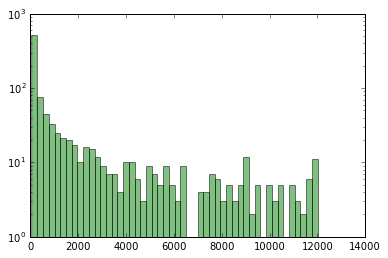

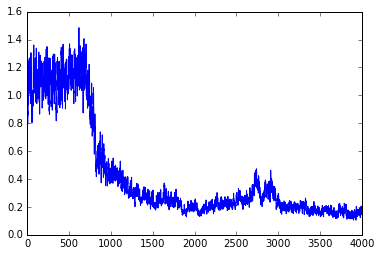

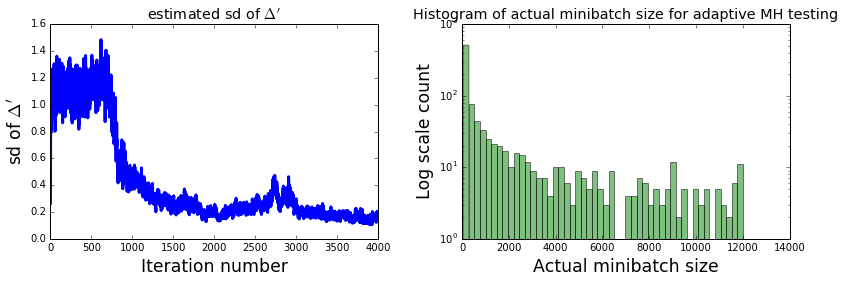

In [29]:
plt.hist(accept_pos_xl, bins = 50, log = True, facecolor='green', alpha=0.5)
plt.show()
plt.plot(sd_array)
plt.show()
fig, axarr = plt.subplots(1,2, figsize=(12, 4))

axarr[0].set_title("estimated sd of $\Delta'$", size="x-large")
axarr[0].plot(sd_array, 'b', lw = 3)
axarr[0].set_xlabel('Iteration number', size="xx-large")
axarr[0].set_ylabel("sd of $\Delta'$", size="xx-large")
# axarr[0].legend([line_up, line_mid] , ['adaptive MH', 'minibatch MH'],  loc='lower right', fontsize="xx-large")
axarr[0].set_xlim([0,4000])
axarr[0].set_ylim([0,1.6])

axarr[1].set_title("Histogram of actual minibatch size for adaptive MH testing", size="x-large")
axarr[1].hist(accept_pos_xl, bins = 50, log = True, facecolor='green', alpha=0.5)
axarr[1].set_xlabel('Actual minibatch size', size="xx-large")
axarr[1].set_ylabel('Log scale count', size="xx-large")
# axarr[1].legend([line_up, line_mid],  ['adaptive MH', 'minibatch MH'],  loc='lower right', fontsize="xx-large")
#axarr[1].set_xlim([0,200000])
#axarr[1].set_ylim([-25,0])

plt.tight_layout()
plt.savefig('appendixExp2.png', dpi=200)

In [34]:
# model class
# assume binary classes, 1 or -1
class Logistic:
    def __init__(self, num_featurs, totN, proposer = None):
        # init the feature vector
        self.p = num_featurs
        self.proposer = proposer
        self.N = totN  # tot number of datas
    
    def ll(self, feature, X, Y):
        # return the log likelihood avg by n
        res = 0.0
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += np.log(1.0 + np.exp(-1.0 * Y[i] * np.sum(feature * X[i,:])))
        res = res * (-1.0)
        return res / n
    
    def delta(self, f_old, f_new, X, Y, t):
        # t is the temperature
        res = self.ll(f_new, X, Y) * self.N / t - self.ll(f_old, X, Y) * self.N / t
        res += self.proposer.probGenerate(f_new, f_old, X, Y) # new -> old
        res = res - self.proposer.probGenerate(f_old, f_new, X, Y)  # old -> new
        return res
    
    def estimateStdDelta(self, f_old, f_new, X, Y, t):
        """
        function to estimate the sd of delta by one mini-batch data
        """
        tmpN = self.N
        self.N = 1
        [n, p] = X.shape
        tmpDeltaArray = [self.delta(f_old, f_new, np.asarray([X[i,:]]), np.asarray([Y[i]]), 1) for i in range(n)]
        varEst = np.var(tmpDeltaArray)
        varEst = varEst * (1.0 * tmpN / n / t)**2.0 * n
        self.N = tmpN
        return varEst**0.5
        
    
    def grad(self, feature, X, Y):
        # compute the grad of the ll
        [n, p] = X.shape
        n1 = Y.shape[0]
        res = np.zeros(self.p)
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += Y[i] * X[i,:] / (1 + np.exp(Y[i] * np.sum(feature * X[i,:])))
        return res/ n
    def predAcc(self, f, X, Y):
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        N_correct = 0
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5 and Y[i] == 1.0:
                N_correct += 1.0
            elif p < 0.5 and Y[i] == -1.0:
                N_correct += 1.0
        return N_correct / n
    def pred(self, f, X):
        a = X.shape
        if len(a) == 1:
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X)))
            if p > 0.5:
                return 1.0
            else:
                return -1.0
        else:
            [n, p] = X.shape
        res = np.zeros(n)
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5:
                res[i] = 1.0
            else:
                res[i] = -1.0
        return res

In [42]:
def randomPropose(beta, sig):
    p = len(beta)
    res = np.zeros(p)
    res = beta + np.random.normal(0,sig, p)
    return res

def randomData(miniBatchSize, im, label):
    n = label.shape[0]
    id = np.random.choice(n, miniBatchSize)
    img = im[id,:]
    idx = label[id]
    return (img, idx)
# this function will return a xcorr val 
def getRandXcorr(ecdf, sdvect, estimatedSd):
    index = bisect(sdvect, estimatedSd) + 1
    x = ecdf[0,:]
    f = ecdf[index, :]
    u = np.random.random()
    return x[bisect(f, u)]
def moving_avg (targetArray, windownSize):
    n = len(targetArray)
    res = []
    i = windownSize / 2
    while (i < n - windownSize/2):
        res.append(np.mean(targetArray[(i-windownSize/2):(i+windownSize/2)]))
        i+=1
    return res
mat = scipy.io.loadmat('../generateXcorr/XcorrCurves.mat')
ecdfmat = mat['res']
sd_vect = mat['sdval']


0.005
1.00012470515


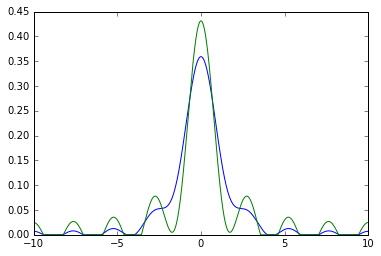

In [5]:
tmp = scipy.io.loadmat('../generateXcorr/x_corr_plot.mat')
tmpRes = tmp['res']
plt.plot(tmpRes[0,:], tmpRes[-17,:])
delta_x = tmpRes[0,1]-tmpRes[0,0]
print delta_x
t = np.sum(tmpRes[-1,:]*delta_x)
print t
plt.plot(tmpRes[0,:], tmpRes[-1,:]/t)

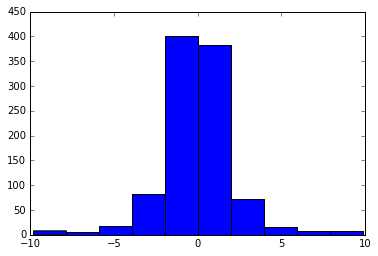

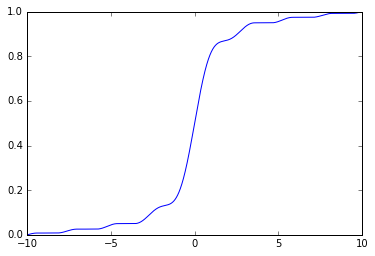

In [5]:
xcorr = np.zeros(1000)
for i in range(1000):
    xcorr[i] = getRandXcorr(ecdfmat, sd_vect, 1.1)
plt.hist(xcorr)
plt.show()
plt.plot(ecdfmat[0,:], ecdfmat[-3,:])

In [6]:
class LangvanProposer:
    def __init__(self, model):
        self.m = model
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.step**0.5, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.step
        return res
        
class RandomWalkProposer:
    def update(self, beta, sig):
        p = len(beta)
        res = np.zeros(p)
        res = beta + np.random.normal(0,sig, p)
        return res
    def probGenerate(self, beta_old, beta_new, X, Y):
        return 1.0

class NoiseGradDescentProposer:
    def __init__(self, model, sd):
        self.m = model
        self.sd = sd
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.sd, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.sd**2
        return res

In [10]:
print TrainImg.shape, TrainLabel.shape

(12007, 784) (12007,)


In [ ]:
# try the mini_batch
N = 2000
p = 784
# beta = np.random.rand(p)
beta = np.ones(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, 12007, rd)
sd_est = 0
sd_array = np.zeros(N)
sd_sd_array = np.zeros(N)
miniBatchSize = 50
num_sd = 40
ll = []
acc = []
ll_full = np.zeros(N)
acc_full = np.zeros(N)
T0 = 1000.0

for i in range(N):
    sd_vect = np.zeros(num_sd)
    T = T0
    sig = sig0
    # jump one step to get the new beta
    beta1 = rd.update(beta, sig)
    
    # estimate the sd of the sd of delta
    for j in range(num_sd):
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        sd_vect[j] = logm.estimateStdDelta(beta, beta1, data[0], data[1], T)
    sd_sd_array[i] = np.std(sd_vect)
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    sd_est = logm.estimateStdDelta(beta, beta1, data[0], data[1], T)
    u = np.random.random()
    sd_array[i] = sd_est
    if sd_est > 1.2:
        ll_full[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0:1000])
        acc_full[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0:1000])
        print sd_est
        continue
    # X_log = ecdf_l[bisect(x_l, u)]
    x_c = getRandXcorr(ecdfmat, sd_vect,sd_est)
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    delta = logm.delta(beta, beta1, data[0], data[1], T)
    if i % 500 == 0:
        print i
    if (delta + x_c > 0):
        beta = beta1
    # data = randomData(200, TestImg, TestLabel)
    # ll.append(logm.ll(beta, data[0], data[1]))
    # acc.append(logm.predAcc(beta, data[0], data[1]))
    ll_full[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0:1000])
    acc_full[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0:1000])

0
1.73784298428
1.30330861144
1.9585181512
1.21224772979
1.29647975556
1.27142454144
2.12768781095
1.23155554423
1.25025411439
1.52212051683
1.51560419145
1.52043744883
1.35658013729
1.31188377786
1.29576459054
1.24881338092
1.6868284811
1.32226988643
1.24756851674
1.23934886805
1.59414234248
1.49171306638
1.29792922893
1.26395347604
1.24597285525
1.57305465062
1.5784995926
1.31687186202
1.26195548617
1.7291703408
1.23324081642
1.25485820308
1.2966570364
1.9784160914
1.26649447859
1.21049321587
1.4047528046
1.37115951567
1.46389190698
1.25430787305
1.27632730014
1.3047120616
1.2941130414
1.43802297514
1.38208311382
1.5663140368
1.44170998427
1.71919218427
1.45693448025
1.337448413
1.36338865895
1.33793453624
500
1.68731606685
1.52052517349
1.20134820882
1.37515923856
1.29641273501
1.20024617959
1.20504844323
1.24836520792
1.3987303116
1.22824374312
1.42368969309
1.30652444484
1.20023334318
1.20458802324
1000
1.2943231133
1500

In [ ]:
plt.plot(sd_array)
plt.plot(sd_sd_array)
plt.show()

In [ ]:
CI_sd_draw = moving_avg(sd_sd_array, 10)
actual_sd_draw = moving_avg(sd_array, 10)

inten = 10
x = [i*inten for i in range(len(CI_sd_draw)/inten)]
CI_sd_draw = np.asarray([CI_sd_draw[i*inten] for i in range(len(CI_sd_draw)/inten)])
actual_sd_draw = np.asarray([actual_sd_draw[i*inten] for i in range(len(actual_sd_draw)/inten)])
sd_up = actual_sd_draw + CI_sd_draw
sd_down = actual_sd_draw - CI_sd_draw

In [ ]:
plt.plot(x, actual_sd_draw)
plt.plot(x, sd_up)
plt.plot(x, sd_down)
plt.show()

In [ ]:
tmp  = np.asarray(sd_sd_array) / np.asarray(sd_array)  
tmp = moving_avg(tmp, 20)
n = len(tmp)
for i in range(n):
    if tmp[i] > 1:
        tmp[i] = tmp[i-1]
plt.plot(tmp)

In [44]:
last_best_ll = ll_full
last_best_acc = acc_full

In [ ]:
plt.plot(sd_array)
plt.show()
print np.mean(sd_array)
plt.plot(ll_full)
plt.show()
plt.plot(acc_full)

In [79]:
ll_full_final = ll_full
acc_full_final = acc_full

In [37]:
previousRes = scipy.io.loadmat('xl0_ones_hyc_final.mat')
cumulate_datasize_xl = previousRes['cumulate_datasize_xl'][0]
cost_list_xl = previousRes['cost_list_xl'][0]
accuracy_xl = previousRes['accuracy_xl'][0]


In [84]:
print accuracy_xl[0].shape

(1000,)


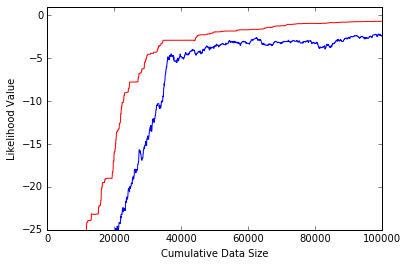

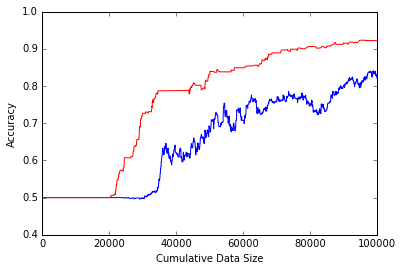

In [88]:
x_ax = np.ones(N) * miniBatchSize
x_ax = np.cumsum(x_ax)
plt.figure()
#plt.plot(cumulate_datasize_xl,cost_list_xl,'r')
#plt.hold(True)
x_ax = np.ones(N) * miniBatchSize
x_ax = np.cumsum(x_ax)
plt.plot(x_ax, ll_full, 'b')
plt.plot(cumulate_datasize_xl,cost_list_xl,'r')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Likelihood Value')
plt.axis([-1,100000,-25,1])

# plt.savefig('ll_hyc.png')
plt.show()


# plot the accuracy with respect to the cumulative data size
plt.figure()
#plt.plot(cumulate_datasize_xl, accuracy_xl, 'r')
#plt.hold(True)
plt.plot(x_ax, acc_full, 'b')
plt.plot(cumulate_datasize_xl, accuracy_xl, 'r')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Accuracy')
plt.axis([0, 100000 ,0.4, 1])

# plt.savefig('acc_hyc.png')
plt.show()

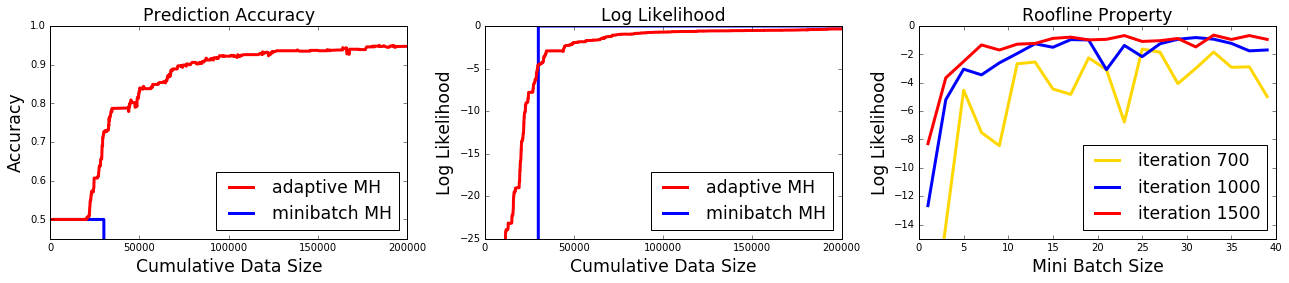

In [60]:
fig, axarr = plt.subplots(1,3, figsize=(18, 4))

axarr[0].set_title("Prediction Accuracy", size="xx-large")
line_mid, = axarr[0].plot(x_ax, acc_full, 'b', lw = 3)
line_up, = axarr[0].plot(cumulate_datasize_xl, accuracy_xl, 'r',lw =3)
axarr[0].set_xlabel('Cumulative Data Size', size="xx-large")
axarr[0].set_ylabel('Accuracy', size="xx-large")
axarr[0].legend([line_up, line_mid] , ['adaptive MH', 'minibatch MH'],  loc='lower right', fontsize="xx-large")
axarr[0].set_xlim([0,200000])
axarr[0].set_ylim([0.45,1.0])

axarr[1].set_title("Log Likelihood", size="xx-large")
line_mid, = axarr[1].plot(x_ax, ll_full, 'b', lw = 3)
line_up, = axarr[1].plot(cumulate_datasize_xl,cost_list_xl,'r', lw =3)
axarr[1].set_xlabel('Cumulative Data Size', size="xx-large")
axarr[1].set_ylabel('Log Likelihood', size="xx-large")
axarr[1].legend([line_up, line_mid],  ['adaptive MH', 'minibatch MH'],  loc='lower right', fontsize="xx-large")
axarr[1].set_xlim([0,200000])
axarr[1].set_ylim([-25,0])

axarr[2].set_title("Roofline Property", size="xx-large")
line_up, = axarr[2].plot(mat['mini_batchArray'][0], mat['ll_full_700_eval'][0], 'gold', lw =3)
line_mid, = axarr[2].plot(mat['mini_batchArray'][0], mat['ll_full_1000_eval'][0], 'b', lw =3)
line_down, = axarr[2].plot(mat['mini_batchArray'][0], mat['ll_full_1500_eval'][0], 'red',lw =3)
axarr[2].set_xlabel('Mini Batch Size', size="xx-large")
axarr[2].set_ylabel('Log Likelihood', size="xx-large")
axarr[2].legend([line_up, line_mid ,line_down],  ['iteration 700', 'iteration 1000', 'iteration 1500'],  loc='lower right'
                ,fontsize="xx-large")
axarr[2].set_xlim([0, 40])
axarr[2].set_ylim([-15,0])

plt.tight_layout()
plt.savefig('exp2.png', dpi=200)

In [70]:
scipy.io.savemat('fianlRes',{'ll_full':ll_full, 'acc_full':acc_full})

In [42]:
mat = scipy.io.loadmat('rooflineData.mat')
print mat
miniba = mat['mini_batchArray']

#plt.plot(mat['mini_batchArray'][0], mat['ll_full_500_eval'][0])


{'ll_full_700_eval': array([[-23.43246978, -14.0605941 ,  -4.52456732,  -7.50822508,
         -8.43698913,  -2.66268158,  -2.53682423,  -4.44063824,
         -4.82072802,  -2.2450926 ,  -3.08096193,  -6.76995565,
         -1.62601592,  -1.84874877,  -4.05967591,  -2.98763478,
         -1.83355635,  -2.91095814,  -2.87686121,  -4.97210754]]), '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat May 14 23:21:32 2016', '__globals__': [], 'll_full_500_eval': array([[-27.63811052, -19.29944577, -19.25749149, -10.61936565,
         -8.47947178, -11.51391777, -13.68016448,  -7.13449421,
         -9.20027458,  -7.71019969,  -4.35277812,  -8.37222993,
         -4.89848144,  -3.99912351, -14.42898055,  -6.07133673,
         -8.60630691,  -9.03301581,  -8.49597962, -17.06331282]]), 'll_full_1500_eval': array([[-8.29596224, -3.65323539, -2.49874424, -1.33476676, -1.69202339,
        -1.28122331, -1.22953089, -0.87242614, -0.78528096, -0.98008606,
        -0.93899666, -0.67587043, -1

In [26]:
best_ll = ll_full
best_acc = acc_full


In [65]:
# non-temperature case:
# try the mini_batch
N = 100
p = 784
# beta = np.random.rand(p)
beta = np.ones(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, 12007, rd)
sd_est = 0
sd_array = np.zeros(N)
miniBatchSize = 1000
num_sd = 10
#ll = []
#acc = []
ll_full_nonT = np.zeros(N)
acc_full_nonT = np.zeros(N)
T0 = 10.0
for i in range(N):
    sd_vect = np.zeros(num_sd)
    T = 1.0
    # sig = sig0 / (i + 1.0)**0.5
    sig = sig0
    beta1 = rd.update(beta, sig)
    for j in range(num_sd):
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        # beta1 = rd.update(beta, sig)
        sd_vect[j] = logm.delta(beta, beta1, data[0], data[1], T)
    sd_est = sd_est *0.7 + np.std(sd_vect) *0.3
    u = np.random.random()
    sd_array[i] = sd_est
    # X_log = ecdf_l[bisect(x_l, u)]
    # x_c = x_corr[bisect(ecdf_corr, u)]
    # x_c = x_c *sd_est
    # beta1 = rd.update(beta, sig)
    # data = randomData(miniBatchSize, TrainImg, TrainLabel)
    # delta = logm.delta(beta, beta1, data[0], data[1], T)
    if i % 500 == 0:
        print i
    # if (delta + x_c > 0):
    #    beta = beta1
    # data = randomData(200, TestImg, TestLabel)
    # ll.append(logm.ll(beta, data[0], data[1]))
    # acc.append(logm.predAcc(beta, data[0], data[1]))
    # ll_full_nonT[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0:1000])
    # acc_full_nonT[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0:1000])

0


270.767364201
1610.67205786


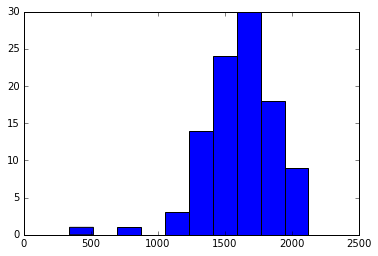

In [64]:
plt.hist(sd_array)
print np.std(sd_array)
print np.mean(sd_array)

22.7610975999
179.079168339


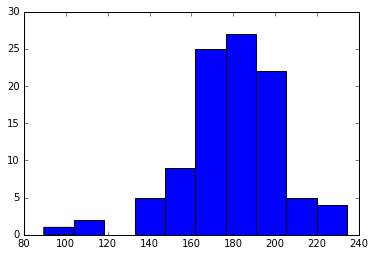

In [66]:
plt.hist(sd_array)
print np.std(sd_array)
print np.mean(sd_array)

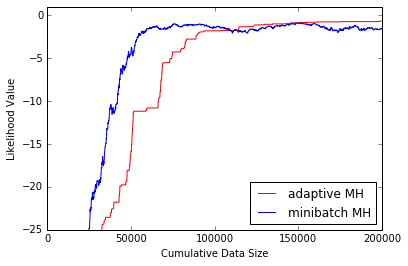

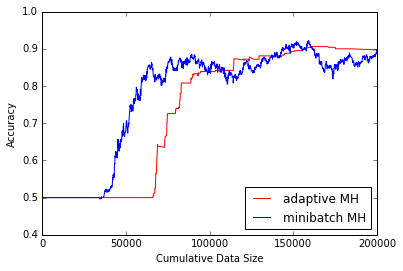

In [33]:
"""
compare the result
"""
# plot the likelihood with respect to the cumulative data size
plt.figure()
line_up, = plt.plot(cumulate_datasize_xl,cost_list_xl,'r')
plt.hold(True)
x_ax = np.ones(N) * miniBatchSize
x_ax = np.cumsum(x_ax)
line_mid, = plt.plot(x_ax, ll_full, 'b')
# line_down, = plt.plot(x_ax, ll_full_nonT, 'y')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Likelihood Value')
plt.axis([-1,200000,-25,1])

plt.legend([line_up, line_mid] , ['adaptive MH', 'minibatch MH'],  loc='lower right')

plt.savefig('ll_hyc.png')
plt.show()


# plot the accuracy with respect to the cumulative data size
plt.figure()
line_up , = plt.plot(cumulate_datasize_xl, accuracy_xl, 'r')
plt.hold(True)
line_mid, = plt.plot(x_ax, acc_full, 'b')
# line_down, = plt.plot(x_ax, acc_full_nonT, 'y')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Accuracy')
plt.axis([0, 200000 ,0.4, 1])

plt.legend([line_up, line_mid],  ['adaptive MH', 'minibatch MH'],  loc='lower right')

plt.savefig('acc_hyc.png')
plt.show()

In [ ]:
scipy.io.savemat('xl0_ones_hyc_final.mat',{'cumulate_datasize_xl':cumulate_datasize_xl, 'cost_list_xl':cost_list_xl, 'accuracy_xl':accuracy_xl})


In [63]:
scipy.io.savemat('xl0_ones_hyc_final.mat',{'cumulate_datasize_xl':cumulate_datasize_xl, 'cost_list_xl':cost_list_xl, 'accuracy_xl':accuracy_xl})
scipy.io.savemat('hy0_ones_hyc_final.mat',{'x_ax':x_ax, 'll_full':ll_full, 'll_full_nonT':ll_full_nonT, 'acc_full':acc_full, 'acc_full_nonT':acc_full_nonT})